In [34]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, "../models/")
from baseline import *
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
# nltk.download('wordnet')
# nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

In [53]:
# utility functions

# display image from thumbnails folder given list of ids
def show_images(imgids):
    for img in imgids:
        try:
            plt.figure();
            img=mpimg.imread('../data/thumbnail/'+img+'.jpg')
            imgplot = plt.imshow(img);
        except:
            plt.close()
            print(img)
    plt.show()

In [37]:
# similarity metrics

# returns number of exact tag overlap
def baseline_score(train,test):
    return len(set(train) & set(test))/len(train)

# returns {exact matches} + eta*{synonym matches}
def syn_score(train, test, eta=0.5):
    score = len(set(train) & set(test))
    for tag in train:
        for syn in wordnet.synsets(tag):
            for name in syn.lemma_names():
                if name in test:
                    score += eta
                    test.remove(name)
    return score / len(train)

# returns sum({exact match}*{tfidf val})
def tfidf_score(tfidf_df, t0, test):
    ref = tfidf_df.loc[test,:]
    score = 0
    for t in t0:
        for i in test:
            if t == i:
                score += ref[i]
    return score

In [51]:
# KNN model 
class KNN():
    # @param k: number of neighbors to return
    def __init__(self, k):
        self.k = k
    
    # @param train: training set of articles 
    # @article_to_image: map of images associated with each article
    def fit(self, train, article_to_image):
        self.train = train
        self.article_to_image = article_to_image
    
    # @param sim: function to return similarity score 
    # @param test_tags: article tags to predict 
    # TODO: tags -> text, use tagging api
    # TODO: implement sep functions for text train and image train
    def predict(self, sim, test_tags):
        self.ranks = {}
        for train_id, train_tags in tqdm(self.train):
            s = sim(train_tags, test_tags)
            if len(self.ranks) < self.k:
                self.ranks[len(self.ranks)] = (train_id, s)
            elif s > min(self.ranks.values(), key=lambda x:x[1])[1]:
                key = min(self.ranks.keys(), key=lambda x:self.ranks[x][1])
                self.ranks[key] = (train_id, s)
        self.ranks = sorted(self.ranks.values(), key = lambda x:x[1], reverse=True)
        print(self.ranks)
        # map to predicted images
        self.pred = []
        for train_id, s in self.ranks:
            print(article_feats['summary'][train_id])
            print(self.article_to_image[train_id])
            self.pred += self.article_to_image[train_id]
        return self.pred
    
    def score(self):
        pass

In [30]:
# extract tag data and format as dictionary

data_dir = "../data/csv_outputs/"
article_feats = {}
image_feats = {}
tag_ref = {'event':'event_tag',
           'org':'org_tag',
           'org_industry':'org_industry_tag',
           'person':'person_tag',
           'person_team':'person_team_tag',
           'person_type':'person_type',
           'place':'place_tag',
           'subject':'subject_tag',
           'summary':'headline_extended'
          }
for csv in tqdm(os.listdir(data_dir)):
    if 'ap_category' not in csv: # skip ap category for now
        df = pd.read_csv(data_dir+csv)
        if 'article' in csv:
            feat = csv[8:-4]
            g = df.groupby("id")[tag_ref[feat]]
            article_feats[feat] = g.apply(lambda x: list(x.astype(str).str.lower()))
        elif 'image' in csv:
            feat = csv[6:-4]
            g = df.groupby("id")[tag_ref[feat]]
            image_feats[feat] = g.apply(lambda x: list(x.astype(str).str.lower()))


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 19.20s/it]


In [35]:
# format accessible image and article corpus
# TODO: some ids don't overlap

images = []
for imgid, tags in tqdm(image_feats['subject'].iteritems()):
    images.append({'imgid':imgid, 'tags': tags})

# images associated with an article
df = pd.read_csv('../data/csv_outputs/image_subject.csv')
g = df.groupby("article_idx")['id']
article_images = g.apply(list).to_dict()

articles = []
# displayable
for articleid, tags in tqdm(article_feats['subject'].iteritems()):
    if articleid in article_images.keys():
        articles.append((articleid,tags))

55145it [00:00, 767959.78it/s]
22602it [00:00, 810828.70it/s]


In [59]:
# images associated with an article
df = pd.read_csv('../data/csv_outputs/image_subject.csv')
g = df.groupby("article_idx")['id']
article_images = g.apply(set).to_dict()

articles = []
# displayable
for articleid, tags in tqdm(article_feats['subject'].iteritems()):
    if articleid in article_images.keys():
        displayable = True
        for img in article_images[articleid]:
            if not os.path.isfile('../data/thumbnail/'+img+'.jpg'):
                displayable = False 
        if displayable:
            articles.append((articleid,tags))

22602it [00:02, 8410.88it/s]


In [60]:
articles[0]

('00c482e2c51942de93495eb98a8bf2e5',
 ['arts and entertainment',
  'general news',
  'sports',
  'movies',
  'nba basketball',
  'professional basketball',
  'basketball',
  "men's basketball",
  "men's sports",
  'television programs',
  'entertainment',
  'corporate legal affairs',
  'corporate news',
  'business',
  'documentaries',
  'nba finals',
  'sports media',
  'nba playoffs'])

['sports', 'nba basketball', 'basketball', 'professional basketball', 'entertainment', 'nba playoffs']


100%|██████████████████████████████████████████████████████████████████████████| 1474/1474 [00:00<00:00, 174940.69it/s]


[('96b084b535dc43e2bde0aa46f98e9c71', 0.5), ('6736ea9085d645868cc7d7f37cfa1d8c', 0.5), ('bab143db9ba442729757c44bfce76317', 0.4444444444444444)]
['the pakistan cricket board moved three psl matches from lahore to karachi on sunday after political and military tension between india and pakistan']
{'b2fdfda6a5bb4e11bb337e2b3fb9c282'}
['doctors say boxer maxim dadashev has had surgery at a maryland hospital for swelling on his brain after collapsing outside the ring after losing a match']
{'f72b5563fdb0476b91f4f9869a27d43e'}
['among 10 things to know: us says iran took mine off tanker but iran denies involvement; emails: trump official consulted climate-change rejecters; raptors beat warriors in 6 games for nba championship']
{'9670772145394a4695d72dadd21bc481'}
['b2fdfda6a5bb4e11bb337e2b3fb9c282', 'f72b5563fdb0476b91f4f9869a27d43e', '9670772145394a4695d72dadd21bc481']


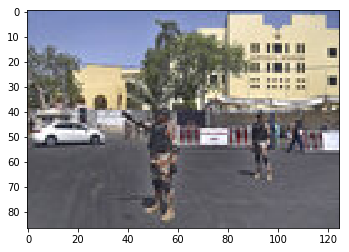

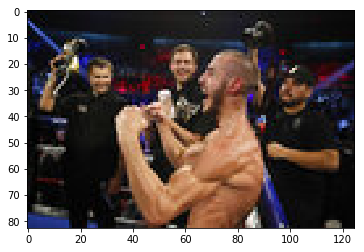

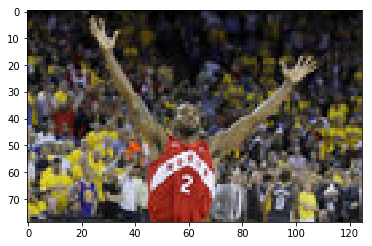

In [68]:
# knn example use case
# predict for first article

train = articles

# test article
test = ['sports','nba basketball','basketball','professional basketball','entertainment','nba playoffs']
print(test)

model = KNN(3)
model.fit(train, article_images)
preds = model.predict(baseline_score, test)
print(preds)
show_images(preds)

100%|████████████████████████████████████████████████████████████████████████████| 1474/1474 [00:00<00:00, 1919.33it/s]


[('6736ea9085d645868cc7d7f37cfa1d8c', 0.5), ('96b084b535dc43e2bde0aa46f98e9c71', 0.5), ('00c482e2c51942de93495eb98a8bf2e5', 0.3888888888888889)]
['doctors say boxer maxim dadashev has had surgery at a maryland hospital for swelling on his brain after collapsing outside the ring after losing a match']
{'f72b5563fdb0476b91f4f9869a27d43e'}
['the pakistan cricket board moved three psl matches from lahore to karachi on sunday after political and military tension between india and pakistan']
{'b2fdfda6a5bb4e11bb337e2b3fb9c282'}
['stephen curry is using a foundation of faith to build a career away from the basketball court through his burgeoning production company']
{'4dab89d356a045058908a8fe6815a414', '76762a71203d478c803f0a607e69176a'}
['f72b5563fdb0476b91f4f9869a27d43e', 'b2fdfda6a5bb4e11bb337e2b3fb9c282', '4dab89d356a045058908a8fe6815a414', '76762a71203d478c803f0a607e69176a']


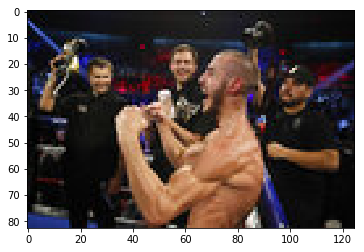

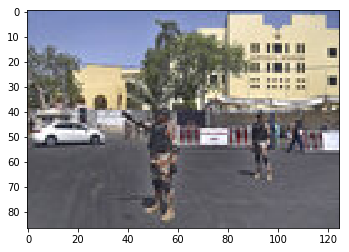

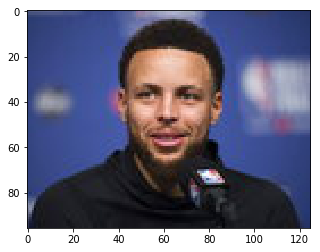

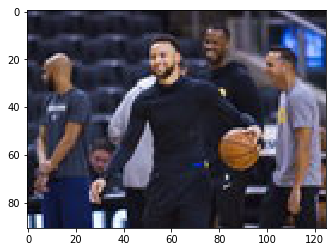

In [69]:
syn_preds = model.predict(syn_score, test)
print(syn_preds)
show_images(syn_preds)

In [12]:
exact_match = baseline_model(test[1], images, 10, baseline_score)
syn_match = baseline_model(test[1], images, 10, lambda x,y: syn_score(x,y,eta=0.5))
print(syn_match)

[('0002c8b6322446a8a9b8f8abaccb4430', 0), ('0006323cab994ddd9c0824d14c2146fd', 0), ('001329af20914404b6609d9b05def407', 0)]
